Overview
1. Using the structure of the RelNet code from 6.883 first homework
2. Loading pre-embedded files 
3. Put together negative examples

What are protein_emb features?? why are they 3 x 32? I'm going to flatten them. should i separate them into channels?
May need zero padding for 1d convolution

In [3]:
%load_ext memory_profiler

from memory_profiler import profile
import os, random, math, argparse
import torch

from model_ABDG_v2 import ProteinGCN
# from data import 
from data import ProteinDataset, get_train_val_test_loader,collate_pool
from utils import randomSeed
import config as cfg
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.cbook


In [4]:
N_way_pos = 5 # Number of ways
N_way_neg = 5
K_shot = 5

aa_num_neighbors = 3 #How many adjacent amino acids to the target?
NBD_SIZE = 1+2*aa_num_neighbors
ISPROTEINGCN_EMBEDDED = False
IS_MULTIPROTEIN = True

DB5ROOT_dir = "/mnt/disks/amanda200/DB5/raw/"

TRAIN_STEPS = 600
STEP_SIZE = 20

#Where to save the results?
OUTDIR = '/mnt/disks/amanda200/relnetoutputs-20201202/'

# Relation Network Code

### Set Up Batching

In [5]:
#NOTE: There are some serious assumptions that we are making in this non-embedded form
#The features will look something like this torch.Size([1, 2392, 50, 43]), indexed by the proteins they match to 
# torch.Size([1, 2392, 50]). What we're doing is simply taking the max of the 3rd dim, compressing to 1,2392,50
#Then taking the max value across the all the atoms in a protein
def make_dictionary(names, folder):
    '''names = list of protein_names, folder = 'emb_ligand', etc '''
    dict_out={}
    for n in names:
        filename = os.path.join(fullpath,folder,n +'.pkl')
        if os.path.exists(filename):
            #print(filename)
            if "emb" in filename:
                amino_emb,_ = torch.load(filename)
            else:
                protein_gcn_raw = torch.load(filename)
                atom_lddt = protein_gcn_raw[1]
                atom_lddt_mip = torch.max(atom_lddt,dim=3)[0].squeeze()
                atom_to_res = protein_gcn_raw[3].squeeze() #the mapping from atom indices to residue
                amino_emb = torch.zeros(len(torch.unique(atom_to_res)),atom_lddt_mip.size()[1])
                for a in torch.unique(atom_to_res):
                    amino_emb[int(a),:],_ = torch.max(atom_lddt_mip[np.where(atom_to_res==a)[0],:],dim=0)
            dict_out[n] = amino_emb
    return dict_out

def loadAdjacencyMatrix(pdb,pdb_dir,chooseBound=True):
    #DB5 specific
    boundchar = 'b'
    if not chooseBound:
        boundchar = 'u'
    #[(500, 64, 'A'), (1116, 141), 'A'],
    adjacencies_full = np.load(os.path.join(pdb_dir, pdb, f'{pdb}_{boundchar}_adjacencies.npy'),allow_pickle=True)
    #     adjacencies_full = np.load(file)
    #Return just amino acids, which is the
    adjacencies_short = [[a[0][1], a[1][1]] for a in adjacencies_full]
    #Correct for the 1-indexing of the PDB to the 0-indexing of the ProteinGCN
    adjacencies_short = np.array(adjacencies_short)-1
    return adjacencies_short

def getInputHACK(inputs):
    return [inputs[0], inputs[1], inputs[2], inputs[4], inputs[5]]

def from_torch(x):
    """
    Convert from a torch tensor to numpy array
    """
    return x.detach().cpu().numpy()

In [6]:
#loading amino embeddings from files and putting into dictionaries
fullpath='/mnt/disks/amanda200/bounddb5_processed/'
protein_names=torch.load(fullpath + 'names.pkl')
#NOTE: there was an extra addition 'prot' that must be removed here
protein_names.remove('prot')

proteins = [n for n in protein_names]
if ISPROTEINGCN_EMBEDDED:
    ligands = make_dictionary(protein_names, 'emb_ligand')
    receptors = make_dictionary(protein_names, 'emb_receptor')        
else:
    ligands = make_dictionary(protein_names, 'ligand')
    receptors = make_dictionary(protein_names, 'receptor')        

In [7]:
# Leaving this old block in case we need to reference what is in these files
# note the 2392 number of atoms is not accurate, but the specific numbers 50 and 43 are consistent across all files
# filename = '/mnt/disks/amanda200/bounddb5_processed/ligand/1GPW.pkl'
# protein_gcn_raw = torch.load(filename)
# atom_lddt = protein_gcn_raw[1] #eg, size: torch.Size([1, 2392, 50, 43])
# atom_lddt_mip = torch.max(atom_lddt,dim=3)[0].squeeze() #eg, size: torch.Size([2392, 50])
# atom_to_res = protein_gcn_raw[3].squeeze() #the mapping from atom indices to residue
# amino_emb = torch.zeros(len(torch.unique(atom_to_res)),atom_lddt_mip.size()[1]) # initialize the [num_amino,50]
# for a in torch.unique(atom_to_res):
#     amino_emb[int(a),:],_ = torch.max(atom_lddt_mip[np.where(atom_to_res==a)[0],:],dim=0)

# 0: torch.Size([1, 2392]) >> list of atoms by atom type (0-166) #final_protein_atom_fea
# 1: torch.Size([1, 2392, 50, 43]) # final_nbr_fea - vectors of 43 that describe the 50 nearest neighbors
# 2: torch.Size([1, 2392, 50]) #final_nbr_fea_idx - atom index of all the near neighbors
# 3: torch.Size([1, 2392]) #final_atom_amino_idx
# 4: torch.Size([1, 2392]) #final_atom_mask
# print(protein_gcn_raw[1].size())
# print(protein_gcn_raw[2][0,100,0]) #Sample atom index of one of the neirhbods
# print(protein_gcn_raw[1][0,100,0,:])
# print(protein_gcn_raw[3][0,-20:-1])


In [10]:
ligand_sizes = [ligands[n].size(0) for n in ligands.keys()]
max_amino_l = np.max(ligand_sizes,0)
receptor_sizes = [receptors[n].size(0) for n in receptors.keys()]
max_amino_r = np.max(receptor_sizes,0)

# print(max_amino_l)
# print(max_amino_r)

In [15]:
labels={}
for protein in protein_names:
    # Load the adjacencey matrix that is a set of pairs of amino acids between ligand and receptors
    adj = torch.load(os.path.join(fullpath,'adjacencies', protein +'.pkl'))
    #Get the indices
    ligand_no = [adj[n][0] for n in np.arange(len(adj))]
    receptor_no = [adj[n][1] for n in np.arange(len(adj))]
    #Make a dense adjacency matrix [Not fully necessary but keeping it for now]
    num_aminos_l = ligands[protein].shape[0]
    num_aminos_r = receptors[protein].shape[0]
    label = torch.zeros((num_aminos_l,num_aminos_r))
    label[ligand_no,receptor_no]=1
    labels[protein]=label

In [ ]:
#Define DB5ROOT_dir first
def generate_local_neighborhoods(protein_name,k,l_or_r='l',boundchar='b'):
    """
    For a protein, we load the pdb, get the original physical locations by the alpha carbon, then get 
    the k-nearest neighbors
    Generates a vector of size (num_aminos, k) of the ordered nearest neighbor
    NOTE: the node itself is included in this set
    
    """
    PBDID = protein_name
    pdb_path = os.path.join(DB5ROOT_dir,PBDID,f'{PBDID}_{l_or_r}_{boundchar}_cleaned.pdb')

    pdb = pd.parsePDB(pdb_path)

    geometry = pdb.getCoords()
    elements = pdb.getNames()
    residues = pdb.getResnums()

    #Chains are characters, 'A','B' etc., just convert to index 0,1,2...
    chains = pdb.getChids()
    _,chains_idx = np.unique(pdb.getChids(),return_inverse=True)    
    #Use the chains to make the residues unique
    reschain = np.transpose([residues,chains_idx]) #Make Nx2 vector
    #Note the 0-indexed residues here
    _,residues_idx = np.unique(reschain,axis=0,return_inverse=True)

    #We only care where the alpha carbons are, so chopping everythign down
    acarbons_indices = np.where(elements=='CA')[0]
    residues_idx = residues_idx[acarbons_indices]
    residues = residues[acarbons_indices] #The original protein residues
    geometry = geometry[acarbons_indices,:]

    kdtree = KDTree(geometry)
    nbd_distances,nbd_indices = kdtree.query(geometry,k)

#     for x in np.arange(geometry.shape[0]):
#         print(nbd_indices[x,:])
        
    return nbd_indices

In [8]:
class MultiProteinTaskLoader:
    def __init__(self, protein_ligands,protein_receptors,complex_adjacencies, batch_size):
        """
        Do not concatenate the characters from different proteins together. When sampling a task,
        sample a protein first before sampling the shots within the alphabet

        proteins: a dictionary mapping from alphabet names to arrays of size (num_characters, num_writers, H, W),
            where num_characters is the number of characters in the alphabet
        batch_size: number of tasks to generate at once
        """
        self.batch_size = batch_size
        #Making the strong assumption that ligands and receptors have the same protein names 
        self.protein_names = list(protein_ligands.keys())
        self.protein_ligands = protein_ligands
        self.protein_receptors = protein_receptors
        self.complex_adjacencies = complex_adjacencies
        self.nbd = NBD_SIZE #The neigborhood around an amino acid
        if ISPROTEINGCN_EMBEDDED:
            self.h_b = 64 #The size of the hidden layer
        else:
            self.h_b = 50
    def __iter__(self):
        """
        Define this class as an iterable that yields a batch of tasks at each iteration when used in a for-loop.
        Each task in the batch should have N_way classes (characters) randomly sampled from a single alphabet in
        the meta-dataset. Each class should have K_shot + Q_queryperclass images; the first K_shot images are 
        the support set and the last Q_queryperclass images are the queries

        return: a batch of tasks, which should be a numpy array shaped
            (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        """
        
        while True:
            batch = torch.as_tensor([])
            #batch = [torch.empty()]
            y_total = [] #all the labels
            for _ in range(self.batch_size):
                # Randomly sample a protein, then sample N_way classes from this proteins positive and negative
                # matching amino acids 
                
                protein_name_batch = np.random.choice(self.protein_names,N_way_pos+N_way_neg)

                
                #                 classes = np.concatenate((np.ones(N_way),np.zeros(N_way)),axis=0);
                supports_queries = torch.zeros((N_way_pos + N_way_neg,2,self.nbd, self.h_b)) # used to be Shape (K_shot + Q_queryperclass, H, W)
                y = np.concatenate((np.ones(N_way_pos),np.zeros(N_way_neg)),axis=0);
                
                s_i = 0 #The index of the support/task
                for i,protein_name in enumerate(protein_name_batch):
                    protein_ligand = self.protein_ligands[protein_name]
                    protein_receptor = self.protein_receptors[protein_name]
                    adjacencies = self.complex_adjacencies[protein_name]

                  
                    #Initialize the set of positive and negative labels
                    pos_labels_lig,pos_labels_receptor = np.where(self.complex_adjacencies[protein_name]>0)
                    neg_labels_lig,neg_labels_receptor = np.where(self.complex_adjacencies[protein_name]==0)
                
                    #Get N_way positive samples, N_way negative samples
                    #NOTE: This even split of pos/neg is an important meta parameter
                    pos_indices = np.random.choice(np.arange(len(pos_labels_lig)), size=1 if y[i] else 0, replace=False)
                    #NOTE: The negative samples can be taken from non-surface residues, which could be uninformative
                    neg_indices = np.random.choice(np.arange(len(neg_labels_lig)), size=0 if y[i] else 1, replace=False)

                    
                    #Here are the indices to positive/negative amino acid pairs and their labels
                    indices_ligand = np.concatenate(( pos_labels_lig[pos_indices],neg_labels_lig[neg_indices]),axis=0);
                    indices_receptor = np.concatenate((pos_labels_receptor[pos_indices],neg_labels_receptor[neg_indices]),axis=0);
                    classes = [y[i]] #[N_way_pos, N_way_neg] #hard-coded to just be one positive and one negative per protein
                    for k,p in enumerate(np.arange(len(classes))):
                        #First dim is whether it's 
                        #(2, max_amino*num_receptors, max_amino*num_ligands)
                        y[s_i] = classes[p]
                        #Grow the local neighborhood with self.nbd

                        for j,n in enumerate(np.arange(-aa_num_neighbors,aa_num_neighbors+1)):
                            if (indices_ligand[p]+n) in range(0,protein_ligand.shape[0]):
                                supports_queries[s_i,0,j,:] = protein_ligand[indices_ligand[p]+n,:]
                            else:
                                supports_queries[s_i,0,j,:] = 0
                            if (indices_receptor[p]+n) in range(0,protein_receptor.shape[0]):    
                                supports_queries[s_i,1,j,:] = protein_receptor[indices_receptor[p]+n,:]
                            else:
                                supports_queries[s_i,1,j,:] = 0
                        s_i +=1 

                #When making the batch, shuffle so we don't memorize positino
                permuted_indices = np.random.permutation(np.arange(len(y)))
                y = torch.as_tensor(y[permuted_indices],dtype=torch.float)
                supports_queries = supports_queries[permuted_indices,:,:,:]
                batch = torch.cat([batch,torch.as_tensor(supports_queries,dtype=torch.float).unsqueeze(0)],dim=0)
                y_total.append(np.array(y))
                
            #WORKS yield np.array(y_total),np.array(batch) # Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)
            yield np.array(y_total),batch

In [9]:
class SingleProteinTaskLoader:
    def __init__(self, protein_ligands,protein_receptors,complex_adjacencies, batch_size):
        """
        Do not concatenate the characters from different proteins together. When sampling a task,
        sample a protein first before sampling the shots within the alphabet

        proteins: a dictionary mapping from alphabet names to arrays of size (num_characters, num_writers, H, W),
            where num_characters is the number of characters in the alphabet
        batch_size: number of tasks to generate at once
        """
        self.batch_size = batch_size
        #Making the strong assumption that ligands and receptors have the same protein names 
        self.protein_names = list(protein_ligands.keys())
        self.protein_ligands = protein_ligands
        self.protein_receptors = protein_receptors
        self.complex_adjacencies = complex_adjacencies
        self.nbd = NBD_SIZE #The neigborhood around an amino acid
        if ISPROTEINGCN_EMBEDDED:
            self.h_b = 64 #The size of the hidden layer
        else:
            self.h_b = 50
    def __iter__(self):
        """
        Define this class as an iterable that yields a batch of tasks at each iteration when used in a for-loop.
        Each task in the batch should have N_way classes (characters) randomly sampled from a single alphabet in
        the meta-dataset. Each class should have K_shot + Q_queryperclass images; the first K_shot images are 
        the support set and the last Q_queryperclass images are the queries

        return: a batch of tasks, which should be a numpy array shaped
            (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        """
        
        while True:
            batch = torch.as_tensor([])
            #batch = [torch.empty()]
            y_total = [] #all the labels
            for _ in range(self.batch_size):
                # Randomly sample a protein, then sample N_way classes from this proteins positive and negative
                # matching amino acids 
                protein_name = np.random.choice(self.protein_names)
                protein_ligand = self.protein_ligands[protein_name]
                
                protein_receptor = self.protein_receptors[protein_name]
                adjacencies = self.complex_adjacencies[protein_name]
                
                num_class = 2 #was len(alphabet) in HW1, but we only want to predict bind or not bind

                #Initialize the set of positive and negative labels
                pos_labels_lig,pos_labels_receptor = np.where(self.complex_adjacencies[protein_name]>0)
                neg_labels_lig,neg_labels_receptor = np.where(self.complex_adjacencies[protein_name]==0)
                
                #Get N_way positive samples, N_way negative samples
                #NOTE: This even split of pos/neg is an important meta parameter
                pos_indices = np.random.choice(np.arange(len(pos_labels_lig)), size=N_way_pos, replace=False)
                #NOTE: The negative samples can be taken from non-surface residues, which could be uninformative
                neg_indices = np.random.choice(np.arange(len(neg_labels_lig)), size=N_way_neg, replace=False)
                
                #Here are the indices to positive/negative amino acid pairs and their labels
                indices_ligand = np.concatenate(( pos_labels_lig[pos_indices],neg_labels_lig[neg_indices]),axis=0);
                indices_receptor = np.concatenate((pos_labels_receptor[pos_indices],neg_labels_receptor[neg_indices]),axis=0);

                classes = np.concatenate((np.ones(N_way_pos),np.zeros(N_way_neg)),axis=0);
                #When making the batch, shuffle so we don't memorize positino
                permuted_indices = np.random.permutation(np.arange(len(classes)))
                                                                         
                supports_queries = torch.zeros((N_way_pos + N_way_neg,2,self.nbd, self.h_b)) # used to be Shape (K_shot + Q_queryperclass, H, W)
                y = torch.zeros(N_way_pos + N_way_neg) #used to be K_shot + Q_queryperclass
                for i,p in enumerate(permuted_indices):
                    #First dim is whether it's 
                    #(2, max_amino*num_receptors, max_amino*num_ligands)
                    y[i] = classes[p]
                    #Grow the local neighborhood with self.nbd
                    for j,n in enumerate(np.arange(-aa_num_neighbors,aa_num_neighbors+1)):
                        if (indices_ligand[p]+n) in range(0,protein_ligand.shape[0]):
                            supports_queries[i,0,j,:] = protein_ligand[indices_ligand[p]+n,:]
                        else:
                            supports_queries[i,0,j,:] = 0
                        if (indices_receptor[p]+n) in range(0,protein_receptor.shape[0]):    
                            supports_queries[i,1,j,:] = protein_receptor[indices_receptor[p]+n,:]
                        else:
                            supports_queries[i,1,j,:] = 0

                #batch.append(supports_queries) #this works
                batch = torch.cat([batch,torch.as_tensor(supports_queries).unsqueeze(0)],dim=0)
                y_total.append(np.array(y))
            #WORKS yield np.array(y_total),np.array(batch) # Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)
            yield np.array(y_total),batch

### Networks

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Feel free to change for those with GPUs

def conv_block(in_depth, out_depth, pool_size=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_depth, out_channels=out_depth, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_depth),
        nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
    )

class BaseNetwork(nn.Module):
    def __init__(self, depth=64, pool_last_two=True):
        """
        Base network for MatchingNetwork, PrototypicalNetwork, and RelationNetwork. The base network should
        define the four convolution blocks in the backbone of the methods.
        """
        super().__init__()
        ### Your code here ###
        pool_size_last_two = 2 if pool_last_two else 1
        self.conv_layers = nn.Sequential( # Input: (batch_size, 1, 28, 28)
            conv_block(1, depth, pool_size=2), # Output (batch_size, depth, 14, 14)
            conv_block(depth, depth, pool_size=2), # Output (batch_size, depth, 7, 7)
            conv_block(depth, depth, pool_size=pool_size_last_two), # Output (batch_size, depth, 3, 3)
            conv_block(depth, depth, pool_size=pool_size_last_two), # Output (batch_size, depth, 1, 1)
        )
    
    def forward(self, feats, labels):
        """
        Forward pass of the neural network
        
        tasks: a torch.float32 tensor of a batch of tasks.
            Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        labels: a torch.long tensor of labels corresponding to tasks.
            Shape (batch_size, N_way)
        
        return: a tuple (loss, accuracy) of two torch.float32 scalars representing the mean loss and
            mean accuracy of the batch
        """
        ### Your code here ###
        #batch_size = feats.size(0)
        #feat = self.conv_layers(tasks.view(-1, 1, H, W))
        #_, depth, h, w = feat.shape
        batch_size, task_no, rec_lig, nbd_size, hidden = feats.shape
        # Feat is shaped (batch_size * N_way * (K_shot + Q_queryperclass), depth, h, w)
        
        
        #feat = feat.view(batch_size, N_way, K_shot + Q_queryperclass, depth, h, w)
        #support_set, queries = feat.unbind(dim=2)
        
        relations, loss, accuracy = self.predictor(feats, labels)
        return relations, loss, accuracy
    
    def predictor(self, support_set, queries, labels):
        """
        Implemented in the subclasses. Calculate the loss and accuracy given the support set, queries, and labels.
        
        support_set: a shape (batch_size, N_way, depth) torch.float32 tensor
        queries: a shape (batch_size, N_way, depth) torch.float32 tensor
        labels: a shape (batch_size, N_way) torch.long tensor corresponding to the labels for the queries
        """
        raise NotImplementedError

In [11]:
@profile
class RelationNetwork(BaseNetwork):
    def __init__(self, depth=32): #depth is protein_no*protein_no
        """
        Define the additional convolution blocks and fully connected layers necessary for Relation Network
        """
        # The backbone for Relation Network doesn't max pool for the last two convolution blocks
        super().__init__(depth=depth, pool_last_two=False)
        ### Your code here ###
#         self.relation_convs = nn.Sequential(
#             conv_block(2 * depth, depth, pool_size=2), # Output (batch_size, depth, 3, 3)
#             conv_block(depth, depth, pool_size=2), # Output (batch_size, depth, 1, 1)
#         )
        
        self.relation_conv1d = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Conv1d(NBD_SIZE,1,padding=1,kernel_size=3),
            nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1),
#             nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        if ISPROTEINGCN_EMBEDDED:
            self.relation_fcs = nn.Sequential(
                nn.Linear(128, 8),
                nn.ReLU(inplace=True),
                nn.Linear(8, 1),
                nn.Sigmoid() #add softmax?
            )
        else:
            self.relation_fcs = nn.Sequential(
                nn.Linear(100, 8),
                nn.ReLU(inplace=True),
                nn.Linear(8, 1),
                nn.Sigmoid() #add softmax?
            )
    def predictor(self, features, labels_):
        """
        receptor_emb = tensor of size (number of amino acids, number of amino embedding features*2)
        return: a tuple (loss, accuracy) of two torch.float32 scalars representing the mean loss and
            mean accuracy of the batch
        """
        ### Your code here ###
        
        batch_size, task_no, rec_lig, nbd_size, hidden = features.shape

#         print(f"features size before combining the features: {features.shape}")
        #make features batch_size*task_no, nbd_size,hidden_size*2
        features_cat = torch.cat([features[:,:,0,:,:], features[:,:,1,:,:]],dim=3).view(-1,nbd_size,2*hidden)
#         print(f"features size after combining the features: {features_cat.size()}")
        
        feats = self.relation_conv1d(features_cat)
        
        #feats is shape (protein_no*protein_no, channel_no,feat_depth)
#         print(f"This is feats after relation_conv1d:{feats.size()}")

        #relations = self.relation_fcs(features_cat) #Experiment 1 20201201
        relations = self.relation_fcs(feats)
        #relations = self.relation_fcs(feats.view(-1,nbd_size*hidden*2)) #original
        #print(f"relations_size: {relations.size()}")

        labels_reshape=labels_.view(-1,1)

        viewable_format = torch.cat((relations.squeeze(1),labels_reshape),dim=1)
#         print(f"relations 0-10vs labels 0-10: {viewable_format[0:10,:]}")
#         print(relations.squeeze())            
        loss = F.mse_loss(relations.squeeze(), labels_reshape.squeeze())
        
        accuracy = (torch.round(relations.squeeze()) == labels_reshape.squeeze()).float().mean() #Fix the bug?
#         accuracy = (torch.round(relations) == labels_reshape).float().mean() #Original bug?
        #print(labels_reshape)
        #print(relations)
        
        #accuracy = (thresholded == labels).float().mean() #this needs to be changed
        #print(f"This is threshold size:{thresholded.size()}")
        #accuracy = (thresholded == labels_reshape).float().sum()/torch.numel(thresholded)
        return relations, loss, accuracy

In [12]:
class LSTMnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.Sequential(
            nn.LSTM(input_size=64,hidden_size=64,bidirectional=True)
            #nn.Sigmoid()
            )
    def predictor(self, features):
        '''
        features should be torch tensor of (# atoms, batch_number, feature_size (64))
        '''
        feat,  (hidden, cell) = self.lstm(features)
        return torch.squeeze(cell).view(-1)

In [13]:
def train(net, num_steps, print_prob=False):
    """
    Train the input neural network for num_steps
    
    net: an instance of MatchingNetwork, PrototypicalNetwork, or RelationNetwork
    num_steps: number of batches to train for
    
    return: the trained net, the training accuracies per step, and the validation accuracies per 100 steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses=[]
    #print(train_metadataset)
    for step, (y,data) in zip(range(num_steps), train_metadataset):
        labels_ = torch.as_tensor(y) #Adding the _ because labels is a globally defined variable
        batch_size = data.size(0)#Will this print the correct size?
        #print(f"batch size of task is: {data.size()}")
        relations, loss, accuracy = net(torch.as_tensor(data, dtype=torch.float32, device=device), labels_)

        opt.zero_grad()
        loss.backward()
        opt.step()
        train_relation, train_loss, train_accuracy = map(from_torch, (relations, loss, accuracy))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        if (step + 1) % STEP_SIZE == 0:
            val_relations, val_loss, val_accuracy, val_labels = evaluate(net, val_metadataset) #whetre are these defined?
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (
                step + 1, train_loss, train_accuracy, val_loss, val_accuracy
            ))
            if print_prob:
                print(f"relations: {val_relations.size()}, labels: {val_labels.size()}")
                print(np.concatenate((val_relations, val_labels.reshape(-1,1)),axis=1))
    return net, train_accuracies,train_losses, val_accuracies, val_losses

def evaluate(net, metadataset):
    """
    Evalate the trained net on either the validation or test metadataset
    
    net: an instance of MatchingNetwork, PrototypicalNetwork, or RelationNetwork
    metadataset: validation or test metadataset
    
    return: a tuple (loss, accuracy) of Python scalars
    """
    with torch.no_grad(): # Evaluate without gradients
        y, eval_batch = next(iter(metadataset)) # Since our evaluation batch_size is so big, we only need one batch
        # Evaluate the net on the batch of tasks. You have to define the labels here too
        ### Your code here ###
        eval_labels= torch.as_tensor(y)
        #print(f"eval_labels size before:{eval_labels.size()}")
        batch_size = len(eval_batch)
        #labels = torch.arange(N_way, device=device).repeat(batch_size).view(batch_size, N_way)
        relations, loss, accuracy = net(torch.as_tensor(eval_batch, dtype=torch.float32, device=device), eval_labels)
        #print(f"eval_labels size before:{relations.size()}")
        eval_labels, relations, loss, accuracy = map(from_torch, (eval_labels, relations, loss, accuracy))
    return relations, loss, accuracy, eval_labels

device="cpu"

# Data Loader to load amino embeddings

### Amino Acid Pairs Relation Net


In [14]:
num_proteins = len(protein_names)
num_train, num_val = int(num_proteins * 0.6), int(num_proteins * 0.2)

# Train, val, test sets
#Note that we've already shuffled the proteins so we can simply divide the indices in order
train_val_test_splits = np.split(list(protein_names), [num_train, num_train + num_val])


sets = [{n: ligands[n] for n in pdbids} for pdbids in train_val_test_splits]
ligands_train, ligands_test, ligands_val = sets

sets = [{n: receptors[n] for n in pdbids} for pdbids in train_val_test_splits]
receptors_train, receptors_test, receptors_val = sets

sets = [{n: labels[n] for n in pdbids} for pdbids in train_val_test_splits]
labels_train, labels_test, labels_val = sets


#For reference, the train batch size was 64, and the test/val was 1600 in HW1

#SingleProtein Case:
if not IS_MULTIPROTEIN:
    train_metadataset = SingleProteinTaskLoader(ligands_train,receptors_train, labels_train,batch_size=64)
    val_metadataset = SingleProteinTaskLoader(ligands_val,receptors_val, labels_val,batch_size=100)
    test_metadataset = SingleProteinTaskLoader(ligands_test,receptors_test, labels_test,batch_size=100)
else:
    train_metadataset = MultiProteinTaskLoader(ligands_train,receptors_train, labels_train,batch_size=64)
    val_metadataset = MultiProteinTaskLoader(ligands_val,receptors_val, labels_val,batch_size=100)
    test_metadataset = MultiProteinTaskLoader(ligands_test,receptors_test, labels_test,batch_size=100)




In [15]:
dump, train_accs,train_loss, val_accs, val_loss = train(RelationNetwork(), TRAIN_STEPS,print_prob=False)


/mnt/disks/amanda200/danaconda3/lib/python3.7/site-packages/memory_profiler.py:693: UserWarning: Could not extract a code object for the object <class '__main__.RelationNetwork'>
  % func)


step=20   train(loss=0.24329, accuracy=0.55469)  val(loss=0.24791, accuracy=0.55)
step=40   train(loss=0.24595, accuracy=0.58594)  val(loss=0.24808, accuracy=0.58)
step=60   train(loss=0.24441, accuracy=0.60625)  val(loss=0.23846, accuracy=0.612)
step=80   train(loss=0.23377, accuracy=0.62969)  val(loss=0.24418, accuracy=0.596)
step=100   train(loss=0.23189, accuracy=0.6125)  val(loss=0.23932, accuracy=0.623)
step=120   train(loss=0.22202, accuracy=0.66406)  val(loss=0.23065, accuracy=0.609)
step=140   train(loss=0.2247, accuracy=0.62813)  val(loss=0.23163, accuracy=0.611)
step=160   train(loss=0.22404, accuracy=0.63281)  val(loss=0.22967, accuracy=0.636)
step=180   train(loss=0.21984, accuracy=0.66406)  val(loss=0.21822, accuracy=0.633)
step=200   train(loss=0.21767, accuracy=0.6625)  val(loss=0.22882, accuracy=0.623)
step=220   train(loss=0.20921, accuracy=0.68125)  val(loss=0.23202, accuracy=0.629)
step=240   train(loss=0.19494, accuracy=0.70781)  val(loss=0.22182, accuracy=0.641)
s

In [16]:
steps_train = 1 + np.arange(len(train_accs))
df_train = pd.DataFrame(list(zip(steps_train, train_accs, train_loss)),columns =['train_step', 'train_accs','train_loss']) 

train_steps_val = (1 + np.arange(len(val_accs)))*STEP_SIZE
df_val = pd.DataFrame(list(zip(train_steps_val, val_accs,val_loss)),columns =['train_step','val_accs','val_loss']) 

# print(df_val)


nbd = NBD_SIZE
train_filename = f'trainRel_emb-{ISPROTEINGCN_EMBEDDED}_nbd-{nbd}_ismulti-{IS_MULTIPROTEIN}.csv'
val_filename = f'valRel_emb-{ISPROTEINGCN_EMBEDDED}_nbd-{nbd}_ismulti-{IS_MULTIPROTEIN}.csv'
print(os.path.join(OUTDIR,train_filename))
df_train.to_csv(os.path.join(OUTDIR,train_filename))
df_val.to_csv(os.path.join(OUTDIR,val_filename))

/mnt/disks/amanda200/relnetoutputs-20201202/trainRel_emb-True_nbd-7_ismulti-False.csv


plot_emb-True_nbd-7_ismulti-False.png


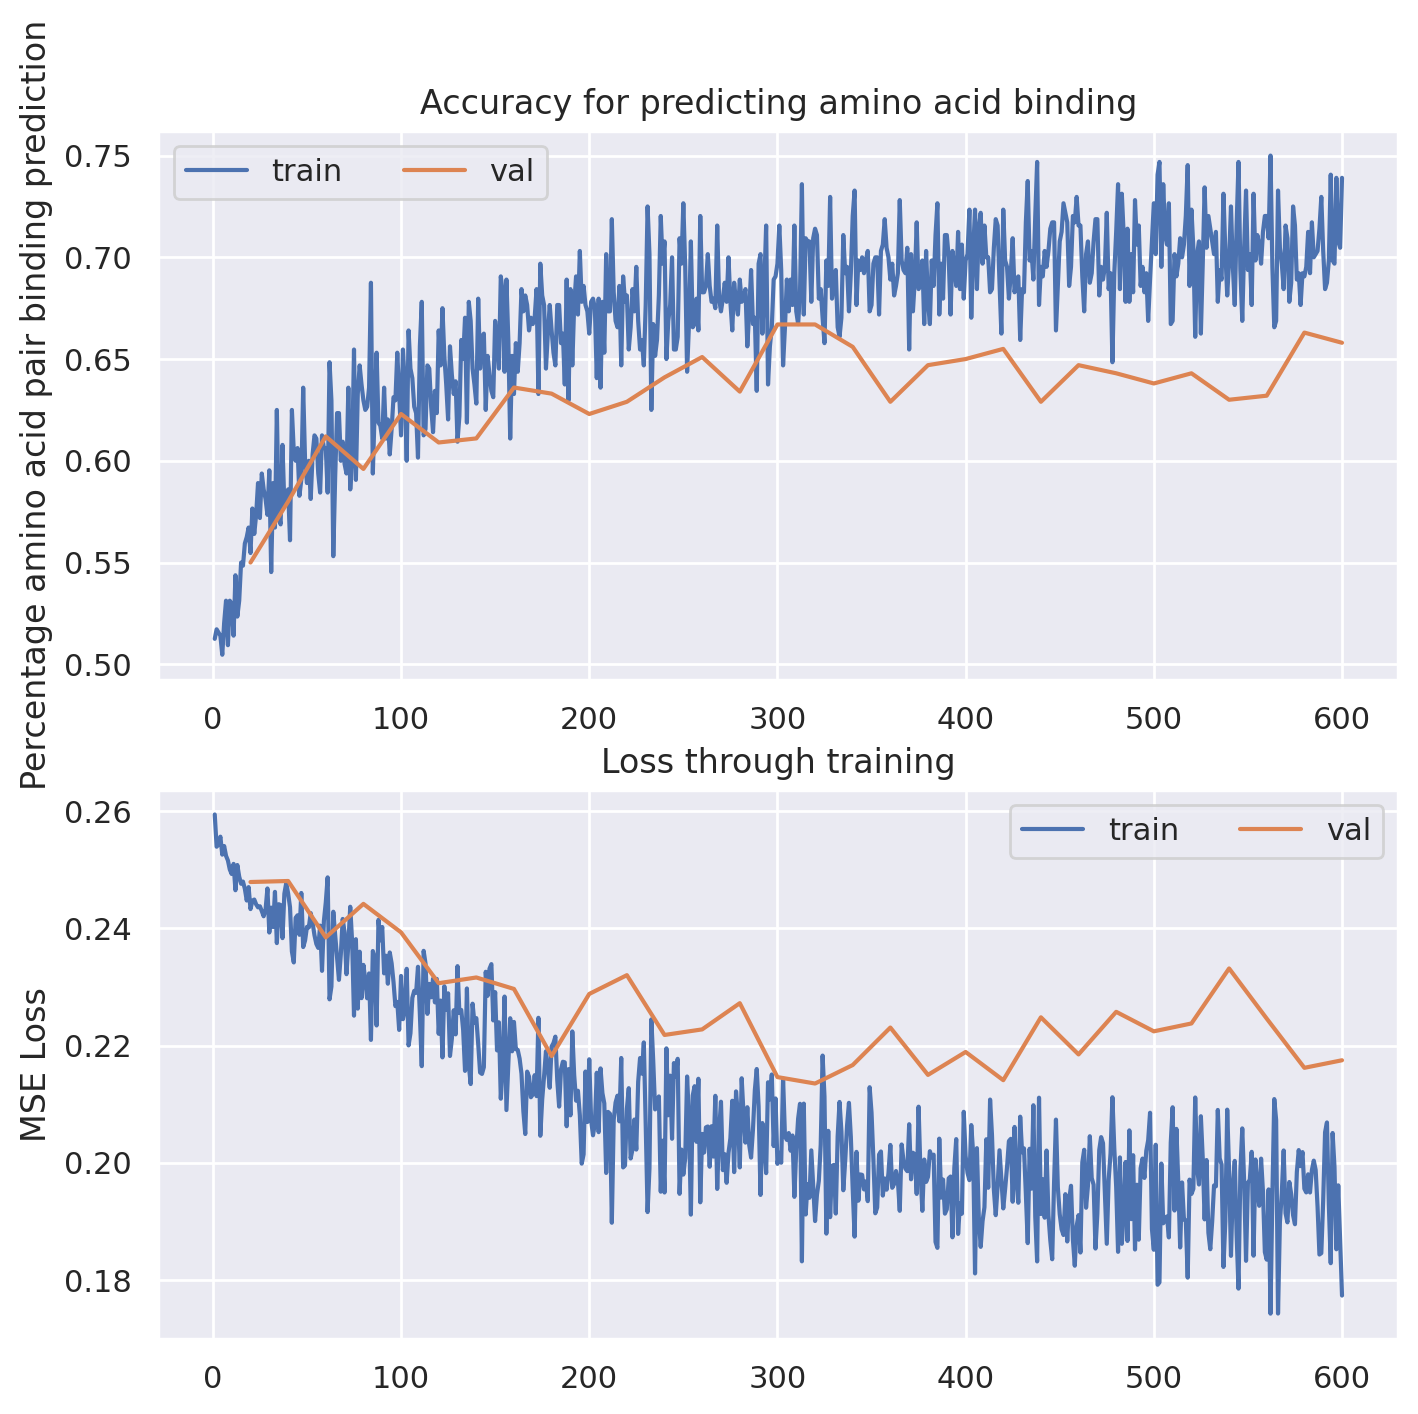

In [17]:

sns.set()
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

plt.figure(num=None, figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')

for p in np.arange(1):
    
    train_filename = f'trainRel_emb-{ISPROTEINGCN_EMBEDDED}_nbd-{nbd}_ismulti-{IS_MULTIPROTEIN}.csv'
    val_filename = f'valRel_emb-{ISPROTEINGCN_EMBEDDED}_nbd-{nbd}_ismulti-{IS_MULTIPROTEIN}.csv'


    df_train_loaded = pd.read_csv(os.path.join(OUTDIR,train_filename))
    df_val_loaded = pd.read_csv(os.path.join(OUTDIR,val_filename))
    
    step_train = df_train_loaded.loc[:,'train_step']
    loss_train = df_train_loaded.loc[:,'train_loss']
    acc_train = df_train_loaded.loc[:,'train_accs']
    
    step_val = df_val_loaded.loc[:,'train_step']
    loss_val = df_val_loaded.loc[:,'val_loss']
    acc_val = df_val_loaded.loc[:,'val_accs']
    

    plt.subplot(2,1,1)
    plt.plot(step_train, acc_train,label="train")
    plt.plot(step_val, acc_val,label="val")

    plt.subplot(2,1,2)
    plt.plot(step_train, loss_train,label="train")
    plt.plot(step_val, loss_val,label="val")


plt.subplot(2,1,1)
plt.ylabel('Percentage amino acid pair binding prediction')
plt.legend(ncol=2, loc='upper left');
plt.title('Accuracy for predicting amino acid binding')
plt.subplot(2,1,2)
plt.ylabel('MSE Loss')
plt.legend( ncol=2, loc='upper right');
plt.title('Loss through training')

figname = f'plot_emb-{ISPROTEINGCN_EMBEDDED}_nbd-{nbd}_ismulti-{IS_MULTIPROTEIN}.png'
print(figname)
plt.savefig(os.path.join(OUTDIR,figname),transparent=True)





Text(0.5, 1.0, 'Loss through training')

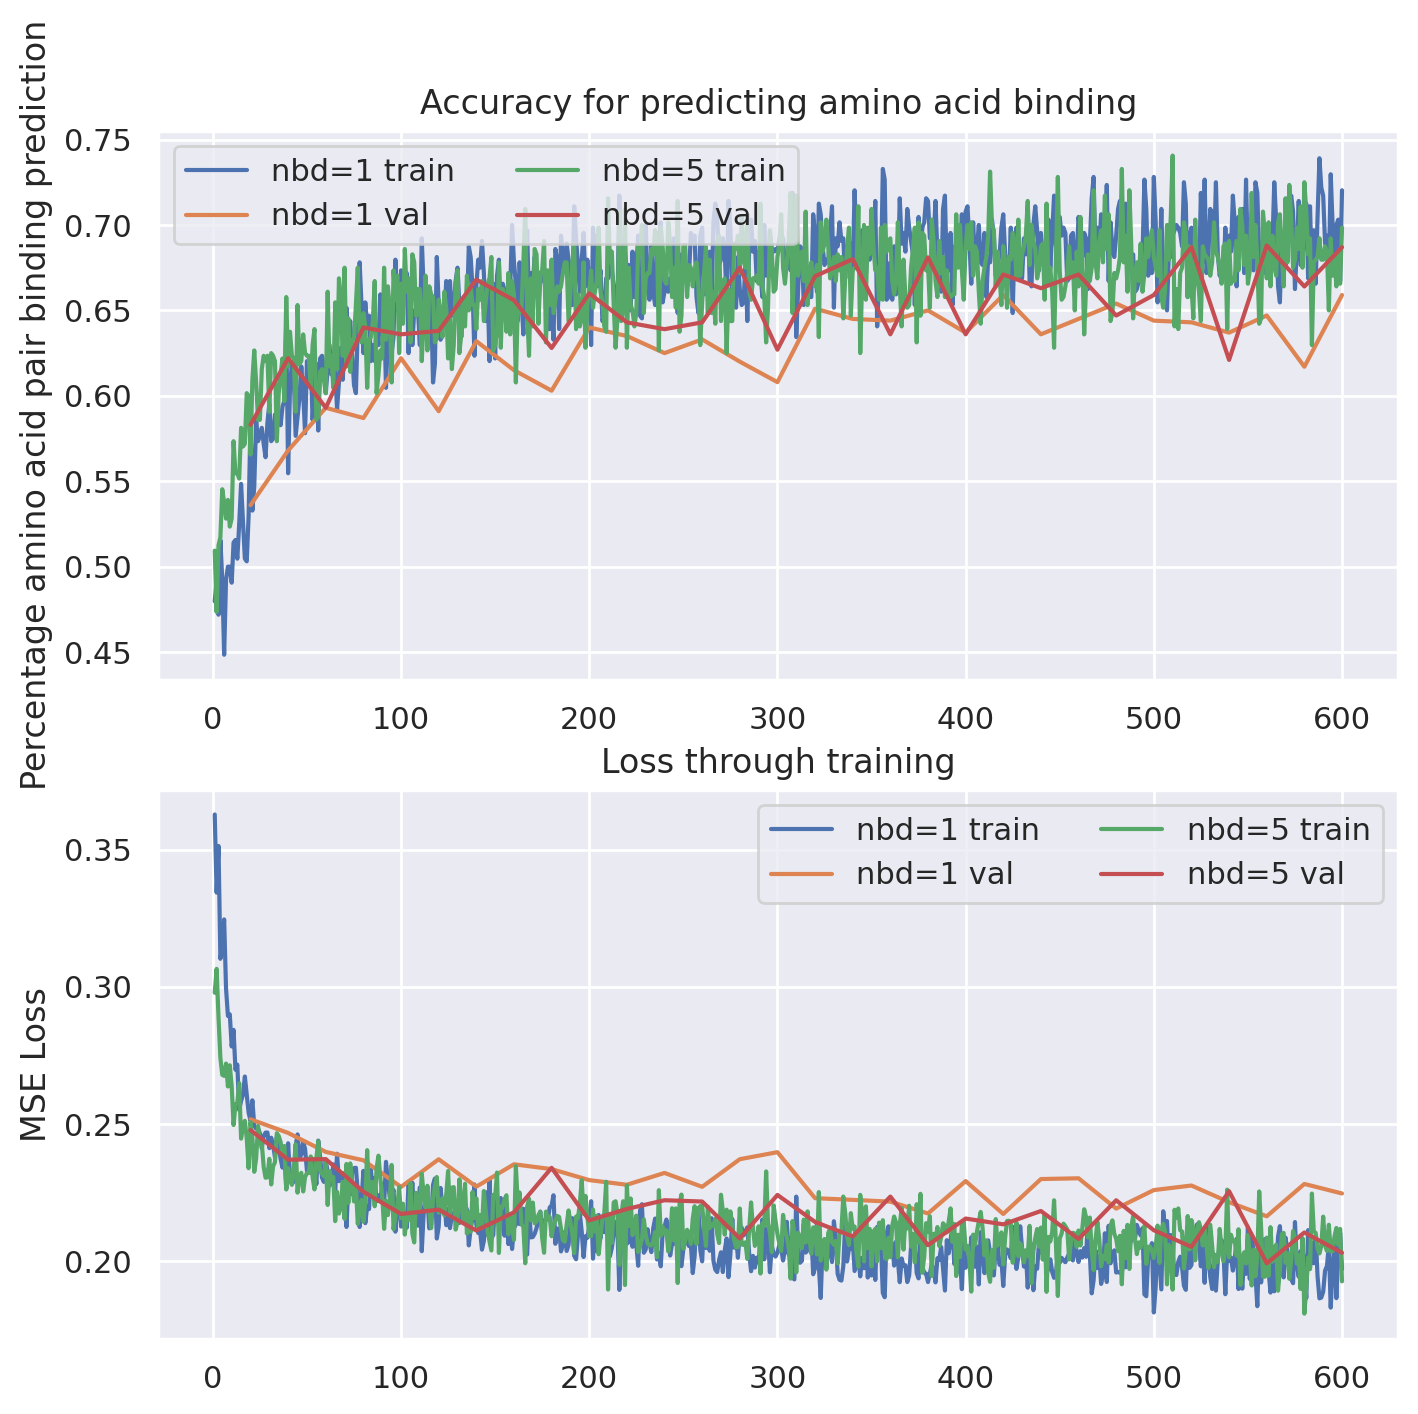

In [33]:
sns.set()
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

plt.figure(num=None, figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')

nbd_=5
file1_train = f'trainRel_emb-{True}_nbd-{5}_ismulti-{True}.csv'
file1_val = f'valRel_emb-{True}_nbd-{5}_ismulti-{True}.csv'
file2_train = f'trainRel_emb-{True}_nbd-{5}_ismulti-{False}.csv'
file2_val = f'valRel_emb-{True}_nbd-{5}_ismulti-{False}.csv'
files_to_load = [(file1_train,file1_val),(file2_train,file2_val)]
prelabels = ['nbd=1','nbd=5']
for p in np.arange(2):
    
    train_filename = files_to_load[p][0]
    val_filename = files_to_load[p][1]


    df_train_loaded = pd.read_csv(os.path.join(OUTDIR,train_filename))
    df_val_loaded = pd.read_csv(os.path.join(OUTDIR,val_filename))
    
    step_train = df_train_loaded.loc[:,'train_step']
    loss_train = df_train_loaded.loc[:,'train_loss']
    acc_train = df_train_loaded.loc[:,'train_accs']
    
    step_val = df_val_loaded.loc[:,'train_step']
    loss_val = df_val_loaded.loc[:,'val_loss']
    acc_val = df_val_loaded.loc[:,'val_accs']
    

    plt.subplot(2,1,1)
    plt.plot(step_train, acc_train,label=f"{prelabels[p]} train")
    plt.plot(step_val, acc_val,label=f"{prelabels[p]} val")

    plt.subplot(2,1,2)
    plt.plot(step_train, loss_train,label=f"{prelabels[p]} train")
    plt.plot(step_val, loss_val,label=f"{prelabels[p]} val")


plt.subplot(2,1,1)
plt.ylabel('Percentage amino acid pair binding prediction')
plt.legend(ncol=2, loc='upper left');
plt.title('Accuracy for predicting amino acid binding')
plt.subplot(2,1,2)
plt.ylabel('MSE Loss')
plt.legend( ncol=2, loc='upper right');
plt.title('Loss through training')




In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot((1 + np.arange(len(train_accs))), train_accs, label="Training Accuracy")
ax1.plot((1 + np.arange(len(val_accs)))*STEP_SIZE, val_accs, label="Validation Accuracy")
ax2.set_xlabel('training step')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2.plot((1 + np.arange(len(val_loss))) * STEP_SIZE, val_loss, label="Validation Loss")
ax2.set_ylabel('validation loss')